<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2: Srinidhi Ilango

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [26]:
import torch
import torch.nn as nn

d:\installations\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [-1.46130851  2.05159559].
The initial velocity of this particle was [-0.24784824  0.28402364].


In [18]:
positions_train[sim_idx, t_idx, :, 1], positions_train[sim_idx, t_idx, (0,1), :]

(array([-0.64291873,  1.93309039]),
 array([[-2.37825743, -0.64291873,  1.60443825,  2.05159559, -3.77503191],
        [ 1.90932565,  1.93309039,  1.0748045 , -1.46130851,  2.61176457]]))

Input: position at time point 0, velocity at time point 0 and charges of 5 particels.
output: position at time point t ( one of 0.5, 1, 1.5) - different models

In [23]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [24]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

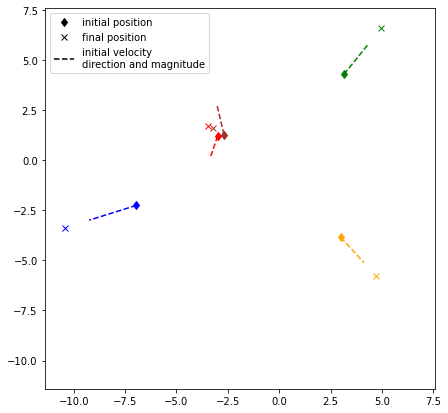

In [25]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [104]:
#todo: based on time index (1,2,3) return the coressponding as y to X at t=0
from torch.utils.data import Dataset, DataLoader,TensorDataset
class MyDataset(Dataset):
    def __init__(self, veloc, pos, charges,time_id=1):
        self.velocity = torch.FloatTensor(veloc)
        self.charges = torch.FloatTensor(charges)
        self.position = torch.FloatTensor(pos)
        self.time_id = time_id
 
    def __getitem__(self, index):
        x_1 = self.velocity[index] #t=0
        x_2 = self.charges[index] #t=0
        x_3 = self.position[index, self.time_id].view(1,2,5)
        y = self.position[index, self.time_id].view(1,2,5)
        return x_1, x_2, x_3, y
        # outputs list of 3 128 batches
        # so [tensor(128, 1 , 4, 5), tensor(128, 1, 5)....]
    def __len__(self):
        return len(self.charges)

In [105]:
time_id = 1
train_set =MyDataset(velocities_train, positions_train, charges_train,time_id)
val_set = MyDataset(velocities_valid, positions_valid, charges_valid,time_id)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128)

In [103]:
# check data
for veloc, charges, position,target in train_loader:
    print(veloc.shape, charges.shape, position.shape, target.shape)
    print("veloc {sim, init_vel, x or y, ptxid} -  charge {sim, ptxid, charge} - pos {sim, time, x or y, ptxd}")
    print("initial velocity",  veloc[0, 0, :, 0])
    print("initial position", position[0,:,])
    print(list(charges.shape))
    # we need to predict from init velocity
    break

torch.Size([128, 1, 2, 5]) torch.Size([128, 5, 1]) torch.Size([128, 1, 2, 5]) torch.Size([128, 1, 2, 5])
veloc {sim, init_vel, x or y, ptxid} -  charge {sim, ptxid, charge} - pos {sim, time, x or y, ptxd}
initial velocity tensor([-0.7878,  0.0267])
initial position tensor([[[-2.3387,  4.4387, -5.1946, -4.0422,  0.4396],
         [-0.2173, -2.9732,  9.4907, -3.3710, -3.1883]]])
[128, 5, 1]


# Model Implementation

The model should be permutation invariant (equivariant?) as all particles interact with one another simultaneously and the order does not matter.

In [40]:
#todo
# Simple NN network for value prediction
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_dim,3)
        self.layer2 = nn.Linear(3, 3)
        self.layer3 = nn.Linear(3, 1)
        # self.drop = nn.Dropout(0.2)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        # x = self.drop(x)
        x = F.relu(self.layer2(x))
        # x = self.drop(x)
        x = F.relu(self.layer3(x))
        return x

In [106]:
learning_rate = 1e-3
weight_decay = 1e-6

loss_fn = nn.MSELoss(reduction="mean") # can do MSE/MAE depends on outliers
model = SimpleModel(input_dim=3)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion=loss_fn
# trainloss, valloss = train(model= model, train_loader= train_loader, n_epochs=5, optimizer= optimizer, criterion=loss_fn)

In [68]:
from tqdm import tqdm
# def train(model, train_loader, n_epochs, optimizer, criterion):
n_epochs = 2
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    running_loss = 0.0
    model.train()

    for veloc, charges, position, y in tqdm(train_loader):

        
    #     size = list(veloc.shape)
    #     for sim in range(size[0]): # batch size per batch
    #         pt_loss = 0.0
    #         for ptxid in range(5):
    #             for coordinate_type in range(2):
    #                 init_veloc_xy = veloc[sim, 0, coordinate_type, ptxid]
    #                 init_pos_xy = position[sim, 0, coordinate_type, ptxid] 
    #                 charge = charges[sim, ptxid, 0]
    #                 x = torch.cat([init_pos_xy.view(1), init_veloc_xy.view(1), charge.view(1)], dim=0) # append pos, veloc, charge to 1 tensor
    #                 y = torch.tensor([position[sim, 1, coordinate_type, ptxid]])
    #                 optimizer.zero_grad()
    #                 outputs = model(x)
    #                 loss = criterion(outputs, y)
    #                 pt_loss += loss.item()
    #                 loss.backward()
    #                 optimizer.step()
    #         pt_loss = pt_loss/10
    #         running_loss += pt_loss
                
    # avg_train_loss = running_loss / (len(train_loader) * 128) # batch size
    # train_losses.append(avg_train_loss)


  0%|          | 0/79 [00:00<?, ?it/s]


IndexError: index 1 is out of bounds for dimension 1 with size 1

# Model Training

In [ ]:
#todo

# Evaluation

In [ ]:
#todo